In [27]:
import numpy as np
import matplotlib as plt
import os
import urllib.parse
import pandas as pd
import re
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns


# Load Data

In [2]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    
    with open(filepath) as f:
        mylist = f.read().splitlines() 
    
    return mylist

In [3]:
good = loadFile("goodqueries.txt")
bad = loadFile("badqueries.txt")

# Process Data

In [4]:
goodY = np.full(len(good),0)
badY = np.full(len(bad),1)

In [5]:
allData = np.concatenate([good,bad])

In [6]:
allLabels = np.concatenate([goodY,badY])

In [7]:
DF = pd.DataFrame(np.array([allData,allLabels]).T,columns = ["path","label"])


In [8]:
def dirChange(tokens):
    counter = 0
    for i in tokens:
        if i == ".." or i == ".|.":
            counter +=1
    return counter

def findIp(querie):
    ip = re.findall( r'[0-9]+(?:\.[0-9]+){3}', querie)   
    return int(len(ip) >= 1)

def countRegex(querie):
    return len(querie) - len(re.findall(r"\w",querie))


In [9]:
#getting features

length = []
tokenNumber = []
tokenRation = []
upDirectory = []
ipExist = []
regexNumber = []

for i in DF["path"]:
    tokens = i.split("/")
    tokens=list(filter(None, tokens))
    length.append(len(i))
    tokenNumber.append(len(tokens))
    try:
        tokenRation.append(len(set(tokens))/len(tokens))
    except:
        tokenRation.append(-1)
        
    upDirectory.append(dirChange(tokens))
    ipExist.append(findIp(i))
    regexNumber.append(countRegex(i))
   
    
DF["length"] = length
DF["tokenNumber"] = tokenNumber
DF["tokenRation"] = tokenRation
DF["upDirectory"] = upDirectory
DF["ipExist"] = ipExist
DF["regexNumber"] = regexNumber


In [10]:
DF.head()

,path,label,length,tokenNumber,tokenRation,upDirectory,ipExist,regexNumber
0,/103886/,0,8,1,1.0,0,0,2
1,/rcanimal/,0,10,1,1.0,0,0,2
2,/458010b88d9ce/,0,15,1,1.0,0,0,2
3,/cclogovs/,0,10,1,1.0,0,0,2
4,/using-localization/,0,20,1,1.0,0,0,3


# Data Analysis

In [11]:
pos = DF[DF["label"] == "1"]
neg = DF[DF["label"] == "0"].sample(frac=1)[:len(pos)]


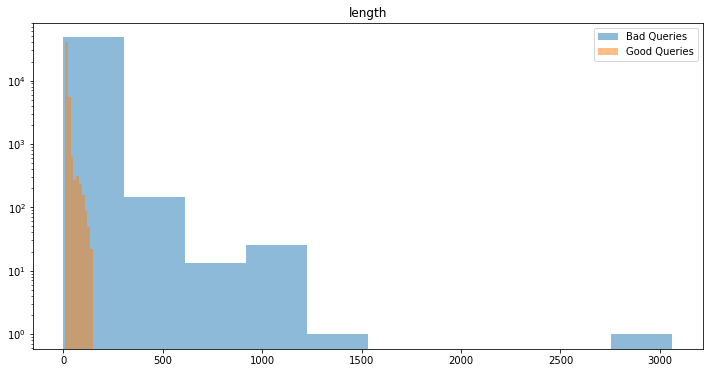

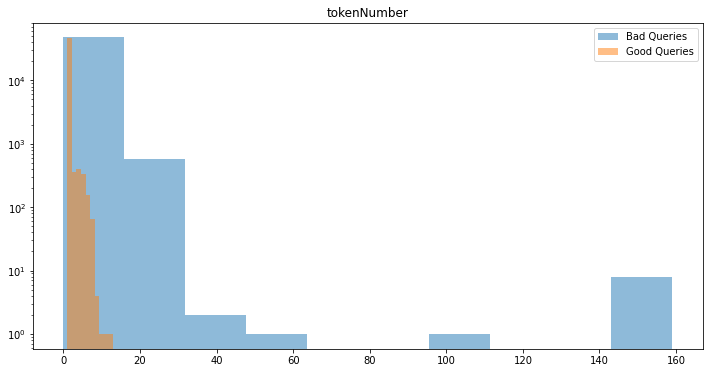

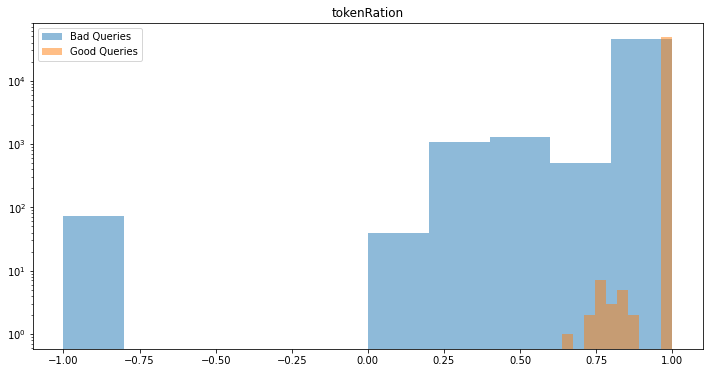

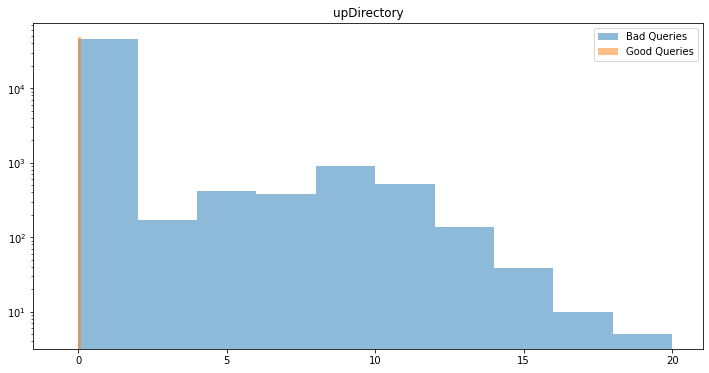

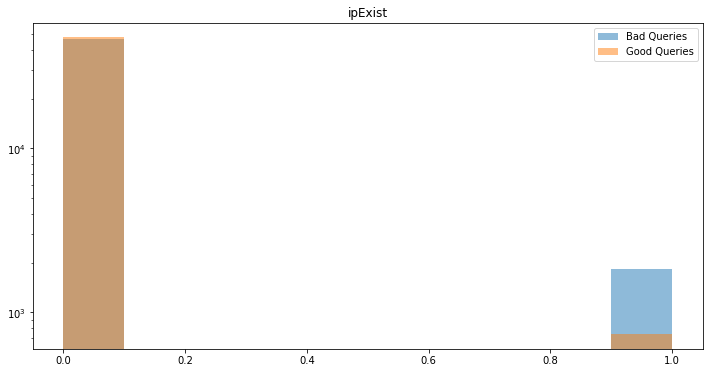

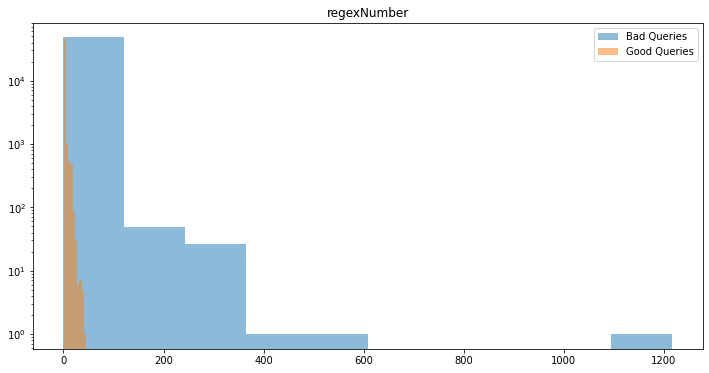

In [12]:
features = pos.columns[2:]

for i in features:
    plt.figure(figsize = (12,6))
    plt.hist(pos[i], alpha = .5, label = "Bad Queries")
    plt.hist(neg[i], alpha = .5, label = "Good Queries")
    plt.yscale("log")
    plt.title(i)
    plt.legend();

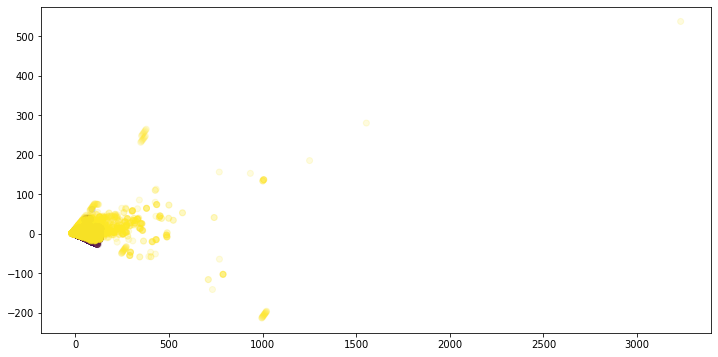

In [13]:
pca = PCA(n_components=2)
pca.fit(DF[DF.columns[2:]])

compressed = pca.fit_transform(DF[DF.columns[2:]])
plt.figure(figsize = (12,6))
plt.scatter(compressed.T[0],compressed.T[1], c = DF["label"].to_numpy(dtype=int), alpha = .15);

# Test-Train Split

In [14]:
data = pd.concat([pos,neg])
data = data.sample(frac = 1) 

In [15]:
train = data.iloc[:int(.8*len(data))]
test = data.iloc[int(.8*len(data)):]

In [16]:
xTrain = train[DF.columns[2:]]
xTest = test[DF.columns[2:]]

yTrain = train["label"]
yTest = test["label"]


In [17]:
scaler = StandardScaler()
scaler.fit(xTrain)

xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

# Model Creation

In [18]:
SVM = SVC().fit(xTrain, yTrain)
LR = LogisticRegression().fit(xTrain, yTrain)
RF = RandomForestClassifier().fit(xTrain, yTrain)
KNN = KNeighborsClassifier().fit(xTrain, yTrain)

In [19]:
SVMPred = SVM.predict(xTest)
LRPred = LR.predict(xTest)
RFPred = RF.predict(xTest)
KNNPred = KNN.predict(xTest)

In [20]:
preds = [SVMPred,LRPred,RFPred,KNNPred]

# Model Analysis


In [25]:
def calculateMetrics(actual, predicted):
    n = len(predicted)
    score_dict = {}
    make_text_bold = lambda x: '\033[1m' + x + '\033[0m'

      # Computes confusion matrix
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    for i in range(n):
        if predicted[i] == actual[i]:
            if predicted[i] ==1:
                TP += 1
            else:
                TN += 1
        else:
            if predicted[i] == 1:
                FP += 1
            else:
                FN += 1
    print('Confusion matrix')
    print('        |    Normal  | Attack  ')
    print(f'Normal |  {TN/n}    | {FN/n}  ')
    print(f'Attack |  {FP/n}    | {TP/n}  ')
    print('Accuracy: ' + str((TP+TN)/(TP+FP+TN+FN)))
    print('TPR: ' + str(TP/(TP+FN)))
    print('FPR: ' + str(FP/(FP+TN)))
    print('F1-Score ' + str(TP/(TP+.5*(FP+FN))))

In [21]:
precision = []
recall = []
f1 = []

for i in preds:
    stuff = metrics.precision_recall_fscore_support(yTest.to_numpy(dtype=str), i, average='macro')
    precision.append(stuff[0])
    recall.append(stuff[1])
    f1.append(stuff[2])


In [22]:
metricData = np.array([precision,recall,f1]).T

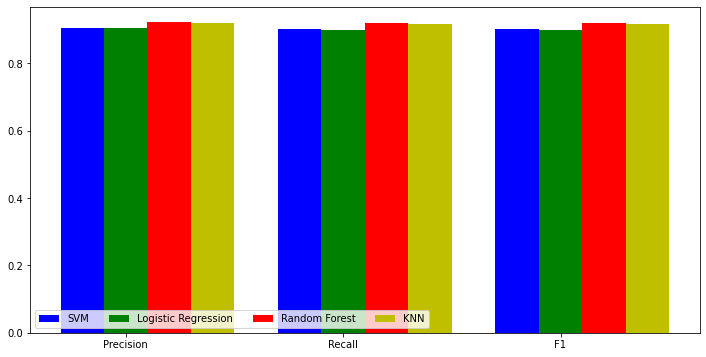

In [23]:
plt.figure(figsize = (12,6))
ax = plt.subplot(111)

x = np.array([1,2,3])

ax.bar(x-0.2, metricData[0] , width=0.2, color='b', align='center', label = "SVM")
ax.bar(x, metricData[1], width=0.2, color='g', align='center', label = "Logistic Regression")
ax.bar(x+0.2, metricData[2], width=0.2, color='r', align='center', label = "Random Forest")
ax.bar(x+0.4, metricData[3], width=0.2, color='y', align='center', label = "KNN")
ax.set_xticks([1,2,3])
ax.set_xticklabels(["Precision","Recall","F1"])

plt.legend(loc="lower left",ncol = 4);

#plt.savefig("Models.png")

In [30]:
confusion_matrix(yTest.to_numpy(dtype=str), preds[2])

array([[9281,  370],
       [1197, 8408]])

In [35]:
TN, FP, FN, TP = confusion_matrix(yTest.to_numpy(dtype=str), preds[2]).ravel()

print('Accuracy: ' + str((TP+TN)/(TP+FP+TN+FN)))
print('TPR: ' + str(TP/(TP+FN)))
print('FPR: ' + str(FP/(FP+TN)))


Accuracy: 0.9186227669297882
TPR: 0.8753774076002082
FPR: 0.03833799606258419


# Model Tuning - Markov Chain Monte Carlo

In [144]:
def fitness(numTrees, maxDepth, minSamples, xTrain, yTrain, xTest, yTest):

    RF = RandomForestClassifier(n_estimators = numTrees,
                                max_depth = maxDepth,
                                min_samples_split = minSamples,
                               n_jobs = -1).fit(xTrain, yTrain)
    RFPred = RF.predict(xTest)
    stuff = metrics.precision_recall_fscore_support(yTest.to_numpy(dtype=str), RFPred, average='macro')
    return(stuff[2])


In [213]:
numTrees = [np.random.randint(100)]
maxDepth = [np.random.randint(100)]
minSamples = [np.random.randint(20)]
score1 = fitness(numTrees[0], maxDepth[0], minSamples[0], xTrain, yTrain, xTest, yTest)
scores = [score1]

steps = 500

for i in range(0,steps):
    
    tempNumTrees = numTrees[i] + np.random.randint(-20,20)
    tempMaxDepth = maxDepth[i] + np.random.randint(-20,20)
    tempMinSamples = minSamples[i] + np.random.randint(-10,10)
    
    if tempNumTrees < 1:
        tempNumTrees = 200
    if  tempMaxDepth < 1:
        tempMaxDepth = 200
    if tempMinSamples < 2:
        tempMinSamples = 50
        
    score2 = fitness(tempNumTrees, tempMaxDepth, tempMinSamples, xTrain, yTrain, xTest, yTest)
    
    p = np.random.random()
    
    if score2 > scores[i] or p > .8:
        numTrees.append(tempNumTrees)
        maxDepth.append(tempMaxDepth)
        minSamples.append(tempMinSamples)
        scores.append(score2)
        print(score2,i)
    else:
        numTrees.append(numTrees[i])
        maxDepth.append(maxDepth[i])
        minSamples.append(minSamples[i])
        scores.append(scores[i])


0.9200151167867239 0
0.9199050126523429 4
0.9202814721856762 7
0.9195064768092599 8
0.919811773843106 9
0.9199619836804308 10
0.9199638362757168 14
0.9203274080080338 19
0.9195480639966296 23
0.9199059794565038 25
0.9195578079727417 26
0.9189872517545035 29
0.9197096074373912 30
0.9203814239357684 31
0.9199661130185931 38
0.9201204371136673 40
0.9198072288511467 43
0.9200174050425325 44
0.9202187877062928 45
0.9204784237552223 49
0.9200645233347284 57
0.9202738201076497 63
0.9198585045587027 64
0.9203754230642169 66
0.9197681736115924 72
0.9195101989582164 73
0.919716826794796 74
0.919716003524306 78
0.919772209173805 79
0.9198737337877139 81
0.9195594890475021 83
0.919979262022097 84
0.920292600406695 91
0.9199709693491995 92
0.9202239228288617 93
0.9199633757271563 95
0.9199747867836745 102
0.9201792669301434 106
0.9197631017371195 107
0.9200205358551424 108
0.9198095230543388 110
0.920488032495773 111
0.9199134640484357 116
0.9201240312916108 119
0.9197582327926673 120
0.92001740504

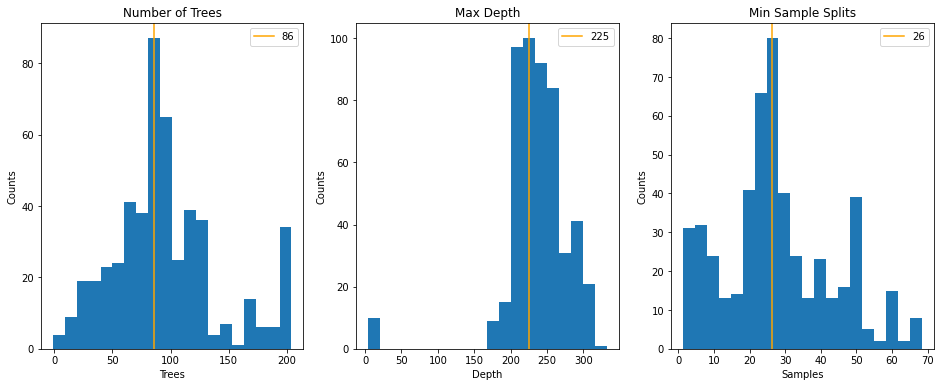

In [219]:
plt.figure(figsize = (16,6))
plt.subplot(1,3,1)
y1, x1, _ = plt.hist(numTrees, bins = 20, align='left')
plt.title("Number of Trees")
plt.xlabel("Trees")
plt.ylabel("Counts")
plt.axvline(x=x1[np.argmax(y1)], c = "orange", label = str(int(x1[np.argmax(y1)])))
plt.legend()

plt.subplot(1,3,2)
y2, x2, _ = plt.hist(maxDepth, bins = 20, align='left')
plt.title("Max Depth")
plt.xlabel("Depth")
plt.ylabel("Counts")
plt.axvline(x=x2[np.argmax(y2)], c = "orange", label = str(int(x2[np.argmax(y2)])))
plt.legend()

plt.subplot(1,3,3)
y3, x3, _ = plt.hist(minSamples, bins = 20, align='left')
plt.title("Min Sample Splits")
plt.xlabel("Samples")
plt.ylabel("Counts")
plt.axvline(x=x3[np.argmax(y3)], c = "orange", label = str(int(x3[np.argmax(y3)])))
plt.legend();

plt.savefig("MCMC.png")

In [215]:
fitness(int(x1[np.argmax(y1)]), int(x2[np.argmax(y2)]), int(x3[np.argmax(y3)]), xTrain, yTrain, xTest, yTest)

0.9199701019745476

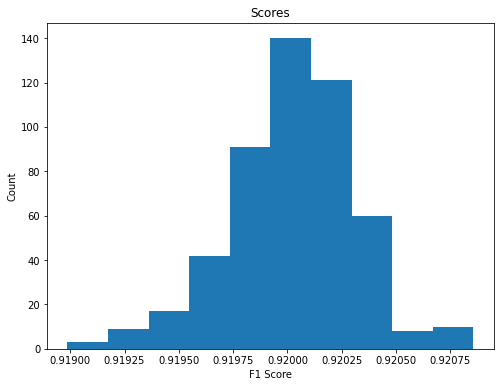

In [224]:
plt.figure(figsize = (8,6))
plt.hist(scores)
plt.title("Scores")
plt.xlabel("F1 Score")
plt.ylabel("Count");
plt.savefig("Score.png")

In [223]:
np.std(scores)

0.0002935909769241207